In [ ]:
# import

!pip install -q bitsandbytes peft datasets trl accelerate transformers tqdm matplotlib

import os, torch, random
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    BitsAndBytesConfig,
)
from peft import LoraConfig, TaskType, get_peft_model
from trl import RewardTrainer, RewardConfig

import json, matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 20.5 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# config

seed = 42
random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

BASE_INST_MODEL = "/content/drive/MyDrive/llm_project/inst_qlora_pytorch_gpt2_medium_dolly"
OUT_DIR = "/content/drive/MyDrive/llm_project/reward_model_gpt2m_trl"
os.makedirs(OUT_DIR, exist_ok=True)

max_length = 256
batch_size = 8
num_epochs = 1
lr = 1e-4
warmup_ratio = 0.05
grad_accum = 2

Running on: cuda


In [ ]:
# Load Anthropic HH-RLHF Dataset

raw = load_dataset("Anthropic/hh-rlhf")
train = raw["train"].shuffle(seed=seed).select(range(4000))
val   = raw["test"].shuffle(seed=seed).select(range(400))

print(train[0].keys(), len(train), len(val))

dict_keys(['chosen', 'rejected']) 4000 400


In [ ]:
# Tokenizer and Model: GPT-2 for Reward (QLoRA)

tokenizer = GPT2Tokenizer.from_pretrained(BASE_INST_MODEL if os.path.exists(BASE_INST_MODEL) else "gpt2-medium")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2-medium",
    num_labels=1,
    quantization_config=bnb_cfg,
    device_map="auto",
)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"],
    task_type=TaskType.SEQ_CLS,
)
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

model.config.pad_token_id = tokenizer.pad_token_id

# initialize small reward head weights (optional)
with torch.no_grad():
    torch.nn.init.normal_(model.score.weight, std=1e-3)
    if model.score.bias is not None:
        torch.nn.init.zeros_(model.score.bias)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,326,400 || all params: 359,150,592 || trainable%: 1.2046


In [ ]:
# Reward configuration

train_steps_per_epoch = len(train) // batch_size
total_steps = train_steps_per_epoch * num_epochs
warmup_steps = int(warmup_ratio * total_steps)

reward_config = RewardConfig(
    output_dir=OUT_DIR,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_accum,
    learning_rate=lr,
    num_train_epochs=num_epochs,
    logging_steps=25,
    save_steps=500,
    eval_strategy="steps",
    eval_steps=100,
    warmup_ratio=warmup_ratio,
    fp16=torch.cuda.is_available() and not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_available() and torch.cuda.is_bf16_supported(),
    report_to="none",             # disable wandb logging
)

print(f'Total steps: {total_steps}')

Total steps: 500


In [ ]:
# RewardTrainer (handles pairwise loss)

trainer = RewardTrainer(
    model=model,
    args=reward_config,
    train_dataset=train,
    eval_dataset=val,
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Adding EOS to train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1866 > 1024). Running this sequence through the model will result in indexing errors


Filtering train >1024 tokens:   0%|          | 0/4000 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Filtering eval >1024 tokens:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
# Train & Evaluate

trainer.train()
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

metrics = trainer.evaluate()

print(metrics)

Step,Training Loss,Validation Loss,Num Tokens,Min Reward,Mean Reward,Max Reward,Accuracy,Margin
100,0.882800,0.899681,712754.000000,-3.601406,-0.484425,3.278885,0.547500,0.180446
200,0.785200,0.741844,1424645.000000,0.656404,2.443370,4.270313,0.562500,0.076665


{'eval_loss': 0.7470681667327881, 'eval_runtime': 132.9034, 'eval_samples_per_second': 2.98, 'eval_steps_per_second': 0.376, 'eval_num_tokens': 1765653.0, 'eval_min_reward': 0.2172186279296875, 'eval_mean_reward': 1.772204360961914, 'eval_max_reward': 3.595, 'eval_accuracy': 0.5575, 'eval_margin': 0.04995620727539062, 'epoch': 1.0}


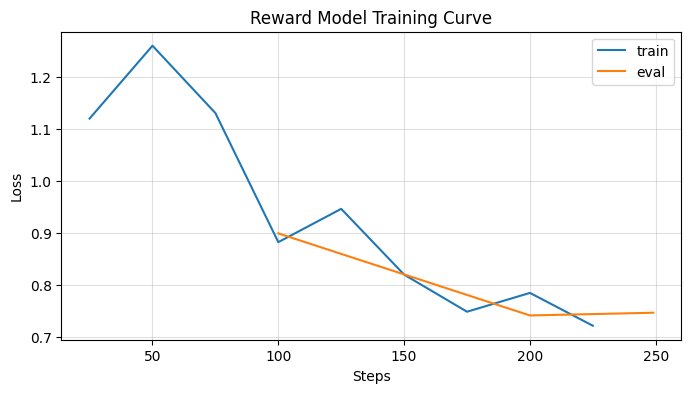

In [ ]:
# Plot loss

logs = trainer.state.log_history

steps = [x["step"] for x in logs if "step" in x]
losses = [x["loss"] for x in logs if "loss" in x]
eval_steps = [x["step"] for x in logs if "step" in x]
eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(8,4))
plt.plot(steps, losses, label="train")
plt.plot(eval_steps, eval_losses, label="eval")
plt.xlabel("Steps"); plt.ylabel("Loss")
plt.title("Reward Model Training Curve")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [ ]:
# Export core dependencies with installed versions

import importlib.metadata as md
import os

core_packages = [
    "torch",
    "transformers",
    "datasets",
    "peft",
    "bitsandbytes",
    "accelerate",
    "trl",
    "tqdm",
    "matplotlib"
]

output_file = os.path.join(os.getcwd(), "requirements.txt")

with open(output_file, "w") as f:
    for pkg in core_packages:
        try:
            version = md.version(pkg)
            f.write(f"{pkg}=={version}\n")
        except md.PackageNotFoundError:
            f.write(f"# {pkg} not installed\n")

print(f"requirements.txt created at: {output_file}\n")
!cat requirements.txt

requirements.txt created at: /content/requirements.txt

torch==2.8.0+cu126
transformers==4.57.1
datasets==4.0.0
peft==0.17.1
bitsandbytes==0.48.2
accelerate==1.11.0
trl==0.25.0
tqdm==4.67.1
matplotlib==3.10.0
